<a href="https://colab.research.google.com/github/yubin-j/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

In [20]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,675 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and dire

- 런타임 -> 세션 다시 시작

In [21]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [3]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree=fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url= html_tree.xpath('string(//img/@src)')
                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [4]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


In [6]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [6]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

NameError: name 'model' is not defined

In [14]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [10]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [8]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? Must say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this is a picture of clothing. Specifically, it is a pair of sneakers, which are a type of footwear designed for casual wear and sports activities. Sneakers like these often feature a combination of materials such as canvas or leather for the upper part and rubber for the sole, providing both comfort and durability. The design elements, such as the color contrast and the style of lacing, suggest that they may be intended for fashion-conscious consumers who value both aesthetics and functionality in their footwear choices.
Yes, this image is of clothing. It appears to be a fashion photograph showcasing a garment, likely for the purpose of advertising or editorial content in a magazine. The focus on the jacket and the model's pose are typical elements used to highlight the design and fit of the clothing item.
No, the image is not of clothing. It is a photograph that appears to be the cover of a book or publication, showcasing an urban scene with two individuals walking along a path 

## 14-6 의류 판단 결과 시각화

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,False
3,,True
4,,True
5,,True
6,,False
7,,True
8,,True
9,,True


## 14-7 의류 이미지 필터링

In [9]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [21]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
3,,True
4,,True
5,,True
7,,True
8,,True
9,,True
10,,True


## 14-8 의류 스타일 분석

In [10]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of th clothes. Please let me explain the colors and trends change'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [24]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The clothing style depicted in the image leans towards a minimalist and modern aesthetic, which is characterized by simplicity, clean lines, and an absence of excessive ornamentation. The color palette is monochromatic, focusing on shades of gray that convey a sense of understated elegance and versatility.\n\nIn terms of trends, this look could be associated with contemporary fashion movements such as streetwear or casual-chic, where comfort meets sophistication. The oversized blazer is a key trend, often seen in high fashion and urban wear, offering a relaxed yet stylish silhouette. This garment's loose fit contrasts with the tailored nature of traditional suits, suggesting a blend of formality and ease.\n\nThe light beige T-shirt underneath adds a subtle contrast to the dark blazer without overwhelming it, adhering to the minimalist principle of pairing pieces thoughtfully. The overall outfit suggests a preference for timeless pieces over fleeting trends, emphasizing quality and enduring style rather than following seasonal fashions.\n\nIt's worth noting that while the exact date of the photo is not provided, the combination of the oversized blazer and the understated color scheme aligns well with fashion trends from recent years, particularly those favoring a more laid-back take on formal attire."
1,,True,"The style of the clothes in the image reflects a casual, possibly outdoor-oriented fashion. The brown jacket and pants are earth-toned colors that are often associated with natural environments or autumnal aesthetics. These colors can be versatile for various settings, from urban to rural.\n\nThe texture of the jacket suggests it is designed for comfort and possibly some level of ruggedness, which could imply suitability for outdoor activities such as hiking or camping. The presence of pockets on both the jacket and pants indicates functionality, which is a common trend in casual wear aimed at practicality.\n\nAs for trends, earth tones have been popular in fashion cycles, often resurfacing due to their timeless appeal and ability to blend with nature. The overall look is understated yet functional, suggesting a preference for comfort over flashy styles. This kind of clothing might also indicate an interest in sustainable fashion, where durability and utility are valued alongside aesthetic considerations.\n\nIn summary, the attire depicted in the image leans towards a practical, comfortable, and earthy style, reflecting current trends that favor functionality and sustainability in everyday wear."
3,,True,"The clothing style in the image reflects a contemporary, minimalist aesthetic with a focus on simplicity and comfort. The use of neutral colors like beige, grey, and brown suggests an understated elegance that is versatile for various occasions. The cardigan over a T-shirt paired with shorts indicates a casual yet put-together look, which has been a popular trend in men's fashion, emphasizing ease of movement and a relaxed vibe.\n\nThe choice of sandals adds to the laid-back feel, suggesting that these outfits are designed for warm weather or indoor settings where comfort is prioritized. The hairstyles and makeup-free looks further enhance the natural and unpretentious appeal of the ensembles. This kind of styling can be seen as part of a broader trend towards gender-neutral fashion, where traditional distinctions between male and female clothing styles are blurred, allowing for more individual expression and personal style choices."
4,,True,"The clothing in the image reflects a casual and contemporary style, with an emphasis on comfort and relaxed aesthetics. The green hoodie is a versatile piece that has seen a resurgence in popularity due to its cozy fit and practical design, suitable for both leisure and informal settings. Hoodies like this one often feature oversized fits and are designed to provide warmth without sacrificing style.\n\nThe light blue denim shirt underneath adds a la

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [11]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(
    model="LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct",
    tensor_parallel_size=1,
    dtype="half",
    gpu_memory_utilization=0.5,
    max_model_len=10000,
    trust_remote_code=True
)

INFO 11-30 18:09:47 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-30 18:09:48 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-30 18:10:10 config.py:549] This model supports multiple tasks: {'score', 'reward', 'classify', 'embed', 'generate'}. Defaulting to 'generate'.
INFO 11-30 18:10:10 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=F

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-30 18:10:14 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-30 18:10:14 cuda.py:226] Using XFormers backend.
INFO 11-30 18:10:15 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-30 18:10:15 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-30 18:13:21 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 185.423887 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-30 18:14:01 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-30 18:14:04 worker.py:267] Memory profiling takes 2.47 seconds
INFO 11-30 18:14:04 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-30 18:14:04 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-30 18:14:04 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-30 18:14:04 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-30 18:14:10 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:45<00:00,  1.31s/it]

INFO 11-30 18:14:56 model_runner.py:1562] Graph capturing finished in 46 secs, took 0.21 GiB
INFO 11-30 18:14:56 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 54.84 seconds


## 14-10 색상 정보 추출

In [12]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-30 18:15:49 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s, est. speed input: 671.50 toks/s, output: 29.47 toks/s]


**색상:**
- 베이지/라이트 탄
- 레드


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s, est. speed input: 1166.35 toks/s, output: 26.94 toks/s]


색상: 검정색, 흰색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, est. speed input: 1289.70 toks/s, output: 27.86 toks/s]


- 갈색 (brown)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s, est. speed input: 571.55 toks/s, output: 33.50 toks/s]


- **maroon**
- **beige**
- **red**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, est. speed input: 390.62 toks/s, output: 37.91 toks/s]


- 검은색 가죽 재킷
- 퍼포레이티드 텍스처 (색상 정보 없음)
- 줄무늬 셔츠


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s, est. speed input: 587.51 toks/s, output: 33.13 toks/s]


- 민트 그린 (Mint Green)
- 블루 (Blue)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, est. speed input: 927.62 toks/s, output: 30.21 toks/s]


색상:
- 검정색
- 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s, est. speed input: 703.68 toks/s, output: 33.72 toks/s]


**색상:**
- **갈색** (Earthy brown)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s, est. speed input: 2304.17 toks/s, output: 18.14 toks/s]

갈색


## 14-11 스타일 키워드 추출

In [13]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it, est. speed input: 115.40 toks/s, output: 39.31 toks/s]


- **클래식**
- **lace-up**
- **low-top**
- **베이지**
- **라이트 탄**
- **토ecap**
- **sole**
- **빈티지**
- **레트로**
- **색상 블록**
- **중립**
- **versatility**
- **기능성**
- **스타일**
- **실용성**
- **현대적**
- **기능과 스타일의 균형**
- ** Versatile**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it, est. speed input: 107.93 toks/s, output: 37.28 toks/s]


- **미니멀리즘**
- **현대적**
- **모노톤**
- **깔끔함**
- **타임리스**
- **기능성**
- **품질**
- **편안함**
- **유연성**
- **심플함**
- **고급스러움**
- **텍스처**
- **품질**
- **실용성**
- **소박함**
- **지속가능성**
- **개인표현**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.60s/it, est. speed input: 203.11 toks/s, output: 39.37 toks/s]


- 실용성
- 패션성
- 도시적 분위기
- 따뜻함
- 편안함
- 아웃도어 활동
- 캐주얼 도시 패션
- 고급스러움
- 세련됨
- 겨울 컬렉션
- 기능성과 패션의 조화
- 자연 친화적 색상
- 계절적 트렌드


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, est. speed input: 178.87 toks/s, output: 39.34 toks/s]


- **미니멀리즘**
- **현대적**
- **중립색**
- **단순컷**
- **실용성**
- **편안함**
- **서브컬처**
- **조화로운 스타일링**
- **유니폼**
- **오픈토**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it, est. speed input: 86.22 toks/s, output: 40.93 toks/s]


- **현대적**
- **도시적**
- **반항적**
- **엣지있는**
- **모터사이클**
- **펑크**
- **록**
- **스트리트웨어**
- **전통적**
- **모던**
- **대조**
- **서브틸**
- **다양성**
- **텍스처**
- **패턴**
- **시각적**
- **유연성**
- **창의적**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it, est. speed input: 219.23 toks/s, output: 38.59 toks/s]


- 캐주얼
- 현대적
- 스트리트웨어
- 민트 그린
- 후드티
- 편안함
- 레이어드
- 블루 데님
- 텍스처
- 빈티지
- 도시적
- 실용적
- 트렌디


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it, est. speed input: 255.28 toks/s, output: 38.13 toks/s]


스타일 키워드:
- 미니멀리즘
- 현대적 미학
- 모노크롬
- 클래식
- 유연성
- 편안함
- 심플함
- 미니멀리즘 트렌드
- 블랙
- 그레이


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it, est. speed input: 243.60 toks/s, output: 38.01 toks/s]


- 캐주얼한 스타일
- 자연친화적
- 야외/어드벤처 영감
- 자연 톤
- 가을 패션 트렌드
- 편안함
- 실용성
- 유연성
- 단순함
- 언더stated 우아함


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it, est. speed input: 248.43 toks/s, output: 37.99 toks/s]

- 캐주얼한 스타일
- 실용적 스타일
- 아웃도어/ rugged
- 내구성
- 실용성
- 기능성
- 편안함
- 최근 구매
- 유지 관리


In [28]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The clothing style depicted in the image leans towards a minimalist and modern aesthetic, which is characterized by simplicity, clean lines, and an absence of excessive ornamentation. The color palette is monochromatic, focusing on shades of gray that convey a sense of understated elegance and versatility.\n\nIn terms of trends, this look could be associated with contemporary fashion movements such as streetwear or casual-chic, where comfort meets sophistication. The oversized blazer is a key trend, often seen in high fashion and urban wear, offering a relaxed yet stylish silhouette. This garment's loose fit contrasts with the tailored nature of traditional suits, suggesting a blend of formality and ease.\n\nThe light beige T-shirt underneath adds a subtle contrast to the dark blazer without overwhelming it, adhering to the minimalist principle of pairing pieces thoughtfully. The overall outfit suggests a preference for timeless pieces over fleeting trends, emphasizing quality and enduring style rather than following seasonal fashions.\n\nIt's worth noting that while the exact date of the photo is not provided, the combination of the oversized blazer and the understated color scheme aligns well with fashion trends from recent years, particularly those favoring a more laid-back take on formal attire.",회색,스타일 키워드:\n- 미니멀리즘\n- 현대적\n- 심플함\n- 클린라인\n- 단색\n- 언더stated elegance\n-Versatility\n- 스트리트웨어\n- 캐주얼-치크\n- 루즈핏\n- 전통적 정장과의 대조\n- 타임리스\n- 품질 중시
1,,True,"The style of the clothes in the image reflects a casual, possibly outdoor-oriented fashion. The brown jacket and pants are earth-toned colors that are often associated with natural environments or autumnal aesthetics. These colors can be versatile for various settings, from urban to rural.\n\nThe texture of the jacket suggests it is designed for comfort and possibly some level of ruggedness, which could imply suitability for outdoor activities such as hiking or camping. The presence of pockets on both the jacket and pants indicates functionality, which is a common trend in casual wear aimed at practicality.\n\nAs for trends, earth tones have been popular in fashion cycles, often resurfacing due to their timeless appeal and ability to blend with nature. The overall look is understated yet functional, suggesting a preference for comfort over flashy styles. This kind of clothing might also indicate an interest in sustainable fashion, where durability and utility are valued alongside aesthetic considerations.\n\nIn summary, the attire depicted in the image leans towards a practical, comfortable, and earthy style, reflecting current trends that favor functionality and sustainability in everyday wear.",갈색,- 캐주얼한 스타일\n- 자연 친화적\n- 가을 분위기\n- 실용적\n- 편안함\n- 내구성\n- 기능성
3,,True,"The clothing style in the image reflects a contemporary, minimalist aesthetic with a focus on simplicity and comfort. The use of neutral colors like beige, grey, and brown suggests an understated elegance that is versatile for various occasions. The cardigan over a T-shirt paired with shorts indicates a casual yet put-together look, which has been a popular trend in men's fashion, emphasizing ease of movement and a relaxed vibe.\n\nThe choice of sandals adds to the laid-back feel, suggesting that these outfits are designed for warm weather or indoor settings where comfort is prioritized. The hairstyles and makeup-free looks further enhance the natural and unpretentious appeal of the ensembles. This kind of styling can be seen as part of a broader trend towards gender-neutral fashion, where traditional distinctions between male and female clothing styles are blurred, allowing for more individual expression and personal style choices.",- 베이지 (Beige)\n- 회색 (Grey)\n- 갈색 (Brown),- **현대적**\n- **미니멀리즘**\n- **단순함**\n- **편안함**\n- **무채색**\n- **내성적 우아함**\n- **캐주얼**\n- **편안한**\n- **자연스러움**\n- **개인적 표현**\n- **성별 중립**
4,,True,"The clothing in the image reflects a casual and contemporary

## 14-12 텍스트 데이터 정제

In [14]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

## 14-13 워드 클라우드 생성 및 시각화

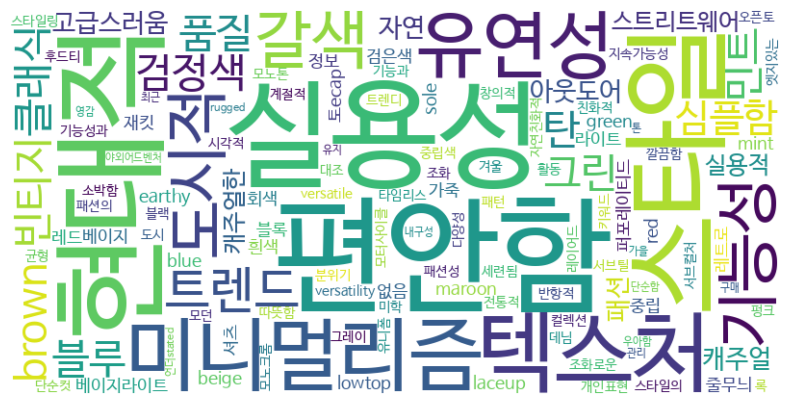

In [22]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [18]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 명확하게 작성해주세요. 문서 형식은 마크다운입니다. 예시 이미지를 적절한 곳에 추가해서 바로 볼 수 있도록 해주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:25<00:00, 25.31s/it, est. speed input: 112.90 toks/s, output: 38.64 toks/s]


In [19]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 트렌드를 종합적으로 분석하고, 이를 통해 현재 패션 산업의 방향성을 제시합니다. 다양한 이미지와 함께 주요 스타일 요소와 그 의미를 상세히 살펴봅니다.

## 트렌드 분석

### 1. **미니멀리즘과 기능성의 융합**
- **예시 이미지**: [John Bull Fall Winter 2025 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/johnbull-fall-winter-2025-collection-lookbook-01-1024x683.jpg)
  - **특징**: 중성적인 색상 팔레트와 단순한 디자인 요소를 활용한 스타일.
  - **트렌드**: 편안함과 스타일의 균형을 추구하며, 다양한 상황에 유연하게 대응 가능한 wardrobe 구축.
  - **분석**: 현대 패션은 기능성과 미니멀리즘을 결합하여 실용성과 세련됨을 동시에 제공하는 방향으로 진화하고 있습니다.

### 2. **클래식과 현대적 해석의 조화**
- **예시 이미지**: [Graphpaper Spring Summer 2026 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/graphpaper-spring-summer-2026-collection-lookbook-17-1024x682.jpg)
  - **특징**: 전통적인 디자인 요소와 현대적인 디테일의 융합.
  - **트렌드**: 과거의 클래식 스타일을 재해석하여 새로운 세대에 맞게 적용.
  - **분석**: 패션은 시간을 초월한 클래식 요소를 현대적 감각으로 재해석함으로써 지속 가능한 트렌드를 창출하고 있습니다.

### 3. **실용성과 스타일의 균형**
- **예시 이미지**: [Nonnative Undercover Ozism Fall Winter 2025 Collection](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/nonnative-undercover-ozism-fall-winter-2025-collection-01-1024x682.jpg)
  - **특징**: 기능적인 디자인 요소와 편안한 착용감을 겸비한 의류.
  - **트렌드**: 실용성과 스타일을 동시에 추구하는 경향이 두드러짐.
  - **분석**: 아웃도어 활동이나 일상적인 활동에 적합한 의류가 인기를 얻고 있으며, 이는 기능성과 스타일의 균형을 중요시하는 소비자들의 선호도를 반영합니다.

### 4. **색상 팔레트의 변화와 톤 다운**
- **예시 이미지**: [Facetasm Spring Summer 2026 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/facetasm-spring-summer-2026-collection-lookbook-11-1024x683.jpg)
  - **특징**: 중성적인 색상과 톤 다운된 패턴의 활용.
  - **트렌드**: 과도한 색상 대비보다는 조화로운 색상 조합과 텍스처의 중요성 증가.
  - **분석**: 패션 트렌드는 과도한 화려함보다는 조화롭고 세련된 색상 팔레트를 선호하며, 이는 소비자들이 더 개인적이고 균형 잡힌 스타일을 추구하는 경향을 반영합니다.

## 결론
현재 패션 산업은 미니멀리즘과 클래식 스타일의 융합, 실용성과 스타일의 균형, 그리고 톤 다운된 색상 팔레트를 중심으로 진화하고 있습니다. 이러한 트렌드는 소비자들의 개인적 표현과 실용성을 동시에 추구하는 욕구를 충족시키며, 지속 가능한 패션 선택의 중요성을 강조합니다. 앞으로도 이러한 방향성은 패션 디자인과 소비자 선호도에 지속적인 영향을 미칠 것으로 예상됩니다.

---

이 보고서는 다양한 패션 룩북 이미지를 통해 관찰된 트렌드를 종합적으로 분석하고, 그 의미와 미래 전망을 제시하였습니다. 각 이미지 링크를 통해 직접 확인하실 수 있습니다.